In [ ]:
!pip install --index-url https://test.pypi.org/simple/ \
            --extra-index-url https://pypi.org/simple \
            pyampact==0.8.0

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from pyampact import estimate_perceptual_parameters, calculate_vibrato
import re

In [ ]:
feature_dir = "/content/drive/MyDrive/data/audio_reps/VocalSet4/"
note_dir = "/content/drive/MyDrive/data/VocalSet Singing Voice Dataset/librosa_note_info2"
model_output_path = "/content/drive/MyDrive/vibrato_depth_model.pkl"

In [ ]:
singer_to_satb = {
    'f1': 'soprano', 'f2': 'soprano', 'f3': 'soprano', 'f4': 'soprano',
    'f6': 'soprano', 'f7': 'soprano', 'f9': 'soprano',
    'f5': 'alto', 'f8': 'alto',
    'm2': 'tenor', 'm3': 'tenor', 'm7': 'tenor', 'm11': 'tenor',
    'm1': 'bass', 'm4': 'bass', 'm5': 'bass', 'm6': 'bass',
    'm8': 'bass', 'm10': 'bass'
}

train_singers = {'f1', 'f3', 'f4', 'f5', 'f6', 'f7', 'f9', 'm1', 'm2', 'm4', 'm6', 'm7', 'm8', 'm11'}
test_singers = {'f2', 'f8', 'm3', 'm5', 'm10'}

In [ ]:
voice_map = {
    "soprano": 0,
    "alto": 1,
    "tenor": 2,
    "bass": 3
}

In [ ]:
def get_singer_id(filename):
    match = re.search(r'(f\d+|m\d+)', filename.lower())
    return match.group(1) if match else None

In [ ]:
# Define plotting and percentage-checking function
def plot_vibrato_depth_distribution(y_train, threshold_list=[20, 50, 100, 150, 200]):
    y_train_arr = np.array(y_train)
    total = len(y_train_arr)

    print(f"Total examples: {total}\n")

    for threshold in threshold_list:
        kept = np.sum(y_train_arr <= threshold)
        percent = 100 * kept / total
        print(f"Threshold: {threshold:>4} Hz → Kept: {kept:>5} examples ({percent:.1f}%)")

    # Optional: histogram
    plt.figure(figsize=(10, 5))
    plt.hist(y_train_arr, bins=100, color='skyblue', edgecolor='gray')
    for t in threshold_list:
        plt.axvline(t, linestyle='--', label=f"{t} Hz", alpha=0.7)
    plt.title("Vibrato Depth Distribution (Hz)")
    plt.xlabel("Vibrato Depth (Hz)")
    plt.ylabel("Number of Examples")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# === DATA COLLECTION ===
import glob
import os
import numpy as np
import pandas as pd

# For vibrato depth model
X_train_depth, y_train_depth = [], []
X_test_depth, y_test_depth = [], []

# For vibrato rate model
X_train_rate, y_train_rate = [], []
X_test_rate, y_test_rate = [], []

notes_checked = 0

for npz_file in glob.glob(os.path.join(feature_dir, "**", "*_features.npz"), recursive=True):
    rec_name = os.path.basename(npz_file).replace("_features.npz", "")

    # a) Skip files with "straight" in the filename
    if "straight" in rec_name:
        print(f"⏭️ Skipping {rec_name} - contains 'straight'")
        continue

    singer_id = rec_name.split("_")[0]  # assumes filenames start with singer ID like 'f1_'
    note_file = os.path.join(note_dir, f"{rec_name}_notes.csv")

    print("⏳ Processing", rec_name)
    if not os.path.exists(note_file):
        continue

    try:
        note_df = pd.read_csv(note_file)
        data = np.load(npz_file)
        f0 = data["f0"]
        rms = data["rms"]
        M = data["M"]
        print(f"✅ Loaded {rec_name} with {len(note_df)} notes.")

        for _, row in note_df.iterrows():
            print(f"  ⏳ Processing {row['onset']} - {row['offset']}")
            onset = int(np.floor(row["onset"] * 44100 / 512))
            offset = int(np.ceil(row["offset"] * 44100 / 512))
            if offset - onset < 2:
                print(f"⚠️ Skipping {rec_name} - onset {onset} - offset {offset} - too short")
                continue

            f0_seg = f0[onset:offset]
            rms_seg = rms[onset:offset]
            M_seg = M[onset:offset]

            print(len(f0_seg), len(rms_seg), len(M_seg))

            if np.all(f0_seg == 0):
                print(f"⚠️ Skipping {rec_name} - all f0 values are 0")
                continue

            try:
                # result = estimate_perceptual_parameters(f0_seg, rms_seg, M_seg, SR=44100, hop=512/44100, gt_flag=False)
                mean_f0_vals = np.mean(f0_seg)
                detrended_f0_vals = f0_seg - mean_f0_vals
                result = calculate_vibrato(detrended_f0_vals, sr=44100/512)
                vib_depth, vib_rate = result
                print(f"    Estimated vib depth: {vib_depth}")
                print(f"    Estimated vib rate: {vib_rate}")
            except Exception as e:
                print(f"    ⚠️ Failed to estimate vib depth: {e}")
                continue

            mean_f0 = np.mean(f0_seg[f0_seg > 0])
            mean_rms = np.mean(rms_seg)
            duration_sec = row["offset"] - row["onset"]

            # b) Add voice part to the features
            voice_str = singer_to_satb.get(singer_id)
            voice_part = voice_map.get(voice_str)
            if voice_part is None:
                print(f"⚠️ Skipping note in {rec_name} – unknown voice part '{voice_str}'")
                continue
            x = [mean_f0, mean_rms, duration_sec, voice_part]

            notes_checked += 1

            # Filter out musically implausible notes (likely segmentation artifacts)
            if vib_depth < 50 and vib_rate < 10:
                if singer_id in train_singers:
                    X_train_depth.append(x)
                    X_train_rate.append(x)
                    y_train_depth.append(vib_depth)
                    y_train_rate.append(vib_rate)
                    print(f"✅ Added note from {rec_name} to training set.")
                elif singer_id in test_singers:
                    X_test_depth.append(x)
                    X_test_rate.append(x)
                    y_test_depth.append(vib_depth)
                    y_test_rate.append(vib_rate)
                    print(f"✅ Added note from {rec_name} to test set.")
            else:
                print(f"⚠️ Skipping note in {rec_name} - musically implausible (depth > 50 or rate > 10)")

    except Exception as e:
        print(f"⚠️ Skipping {rec_name}: {e}")

print(f"✅ Checked {notes_checked} notes.")
print(f"✅ Collected {len(X_train_depth)} training samples and {len(X_test_depth)} test samples.")

Streaming output truncated to the last 5000 lines.
    ✅ Estimated vib depth: 2.01142201955124
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 2.7051 - 2.8909
18 18 18
    ✅ Estimated vib depth: 4.412216640074471
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 2.8909 - 3.1579
23 23 23
    ✅ Estimated vib depth: 2.93723689686008
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 3.1579 - 3.6107
40 40 40
    ✅ Estimated vib depth: 2.0849304718862114
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 3.6107 - 3.9822
33 33 33
    ✅ Estimated vib depth: 1.354230081228505
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 3.9822 - 4.435
40 40 40
    ✅ Estimated vib depth: 2.0719254086160004
✅ Added note from m8_scales_f_slow_piano_u to training set.
  ⏳ Processing 4.435 - 4.5743
13 13 13
    ✅ Estimated vib depth: 1.4110403777339153
⚠️ Skipping note in m8_scales_f_slo

Total examples: 15358

Threshold:   20 Hz → Kept: 12526 examples (81.6%)
Threshold:   50 Hz → Kept: 15082 examples (98.2%)
Threshold:   75 Hz → Kept: 15280 examples (99.5%)
Threshold:  100 Hz → Kept: 15317 examples (99.7%)
Threshold:  125 Hz → Kept: 15329 examples (99.8%)
Threshold:  150 Hz → Kept: 15335 examples (99.9%)


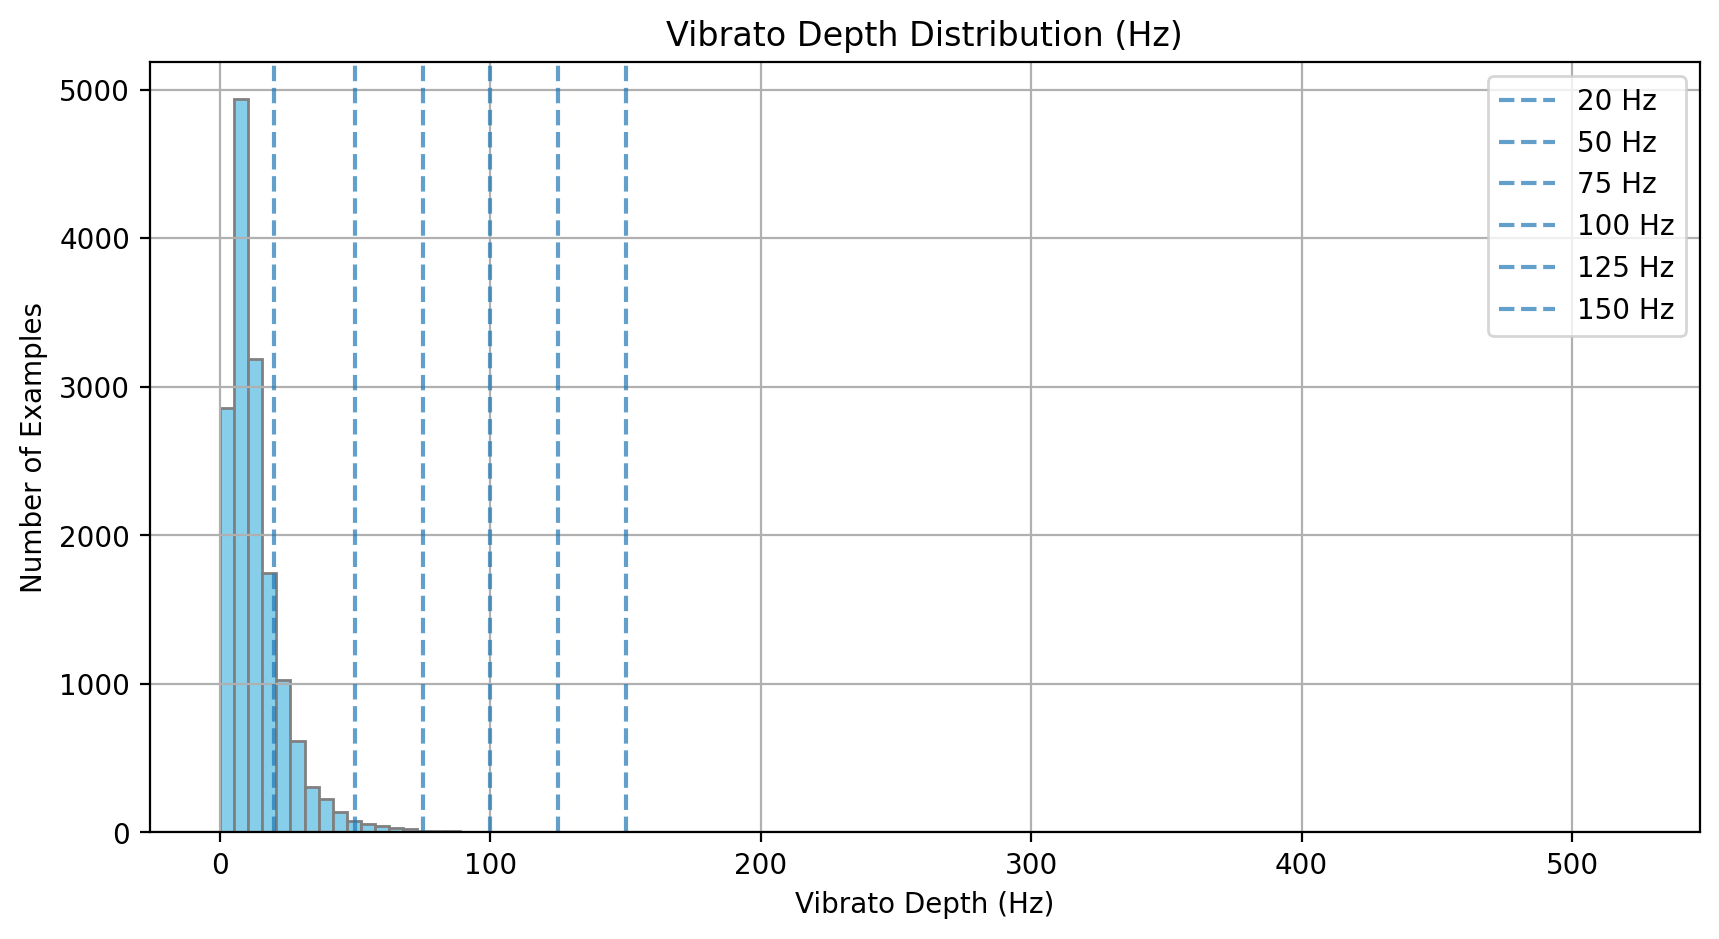

In [ ]:
plot_vibrato_depth_distribution(y_train_depth, threshold_list=[20, 50, 75, 100, 125, 150])

Total examples: 5416

Threshold:   20 Hz → Kept:  4446 examples (82.1%)
Threshold:   50 Hz → Kept:  5308 examples (98.0%)
Threshold:   75 Hz → Kept:  5351 examples (98.8%)
Threshold:  100 Hz → Kept:  5361 examples (99.0%)
Threshold:  125 Hz → Kept:  5372 examples (99.2%)
Threshold:  150 Hz → Kept:  5379 examples (99.3%)


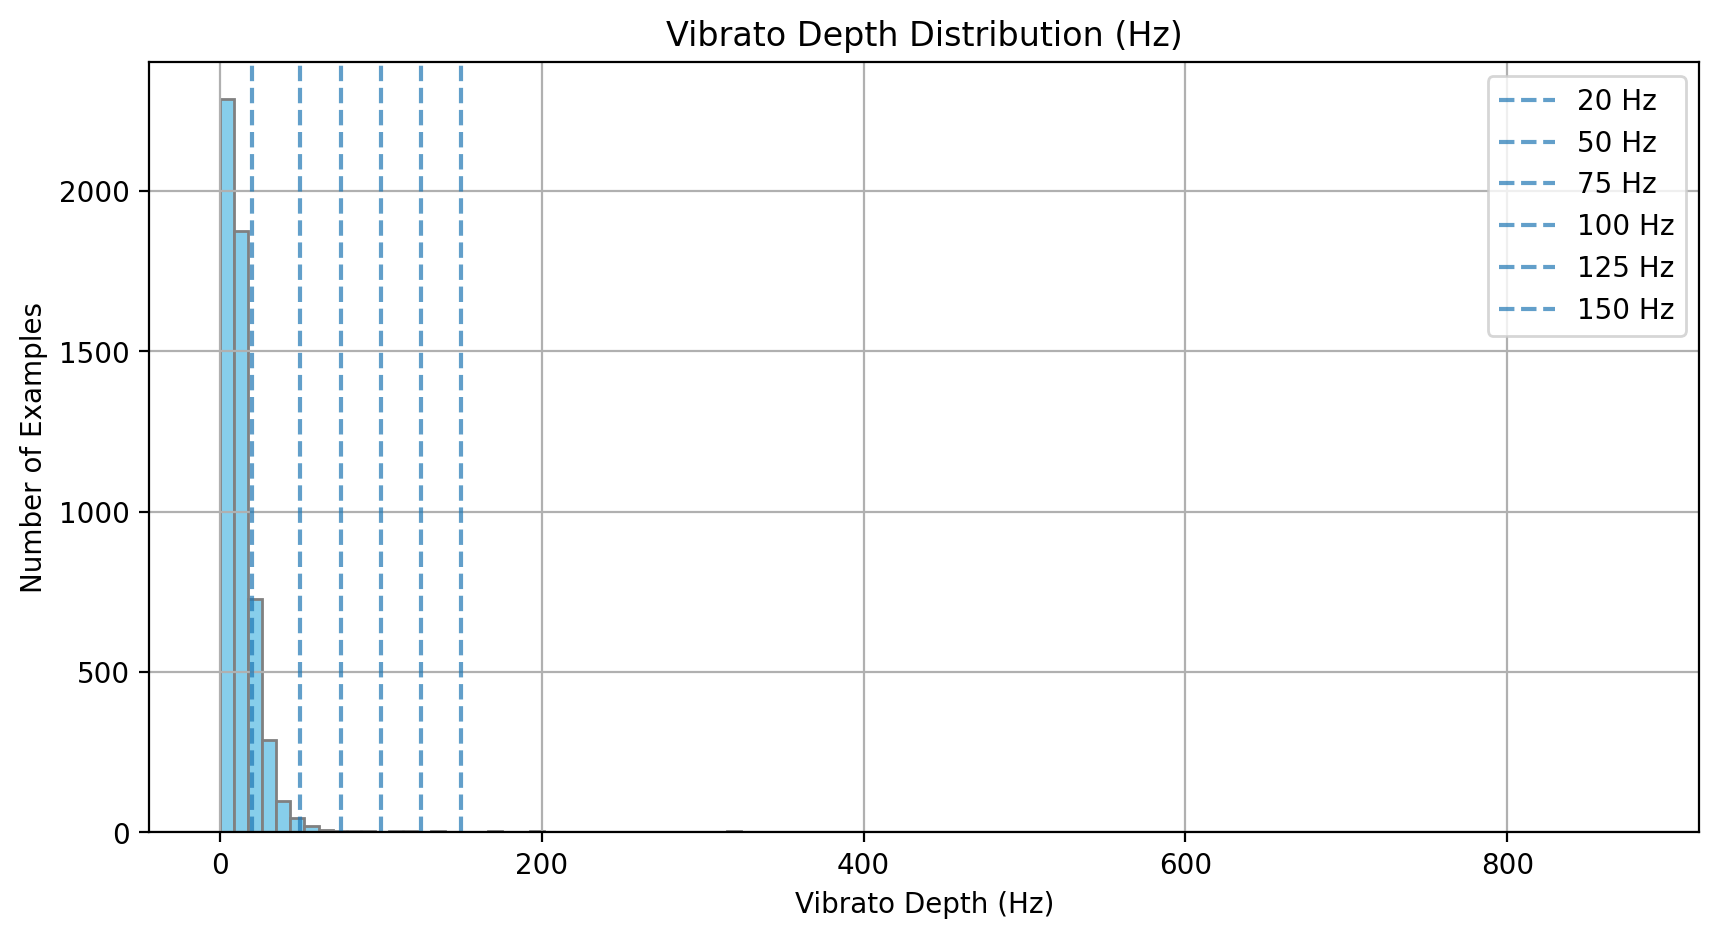

In [ ]:
plot_vibrato_depth_distribution(y_test_depth, threshold_list=[20, 50, 75, 100, 125, 150])

In [ ]:
# === VIBRATO DEPTH MODEL TRAINING AND EVALUATION ===
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train_depth, y_train_depth)

# Evaluate on test set
y_pred_depth = model.predict(X_test_depth)
mae = mean_absolute_error(y_test_depth, y_pred_depth)
r2 = r2_score(y_test_depth, y_pred_depth)

print("\n📊 Test Results:")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

# Optional: save model
model_output_path = "/content/drive/MyDrive/vibrato_depth_model.pkl"
joblib.dump(model, model_output_path)
print(f"✅ Model saved to {model_output_path}")


📊 Test Results:
MAE: 5.817
R²: 0.175
✅ Model saved to /content/drive/MyDrive/vibrato_depth_model.pkl


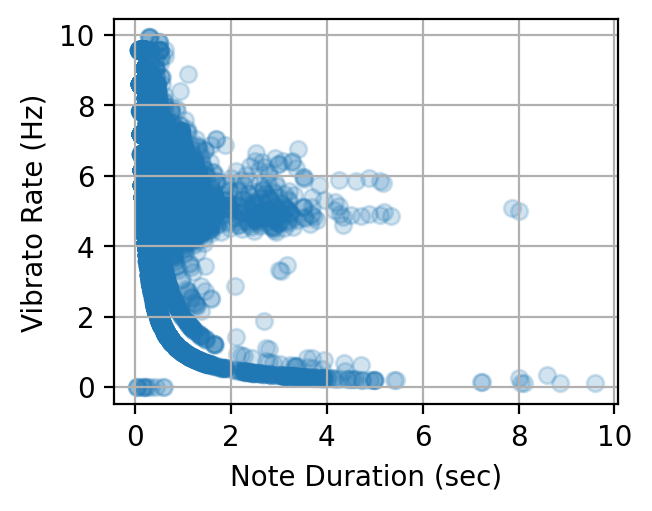

In [ ]:
train_mean_pitch = [x[2] for x in X_train_rate]
plt.figure(figsize=(3.25, 2.5))
plt.scatter(train_mean_pitch, y_train_rate, alpha=0.2) # Reduced alpha
plt.xlabel('Note Duration (sec)')
plt.ylabel('Vibrato Rate (Hz)')
plt.grid(True)
plt.savefig("duration_vs_rate.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# === VIBRATO RATE MODEL TRAINING AND EVALUATION ===
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train_rate, y_train_rate)

# Evaluate on test set
y_pred_rate = model.predict(X_test_rate)
mae = mean_absolute_error(y_test_rate, y_pred_rate)
r2 = r2_score(y_test_rate, y_pred_rate)

print("\n📊 Test Results:")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

# Optional: save model
model_output_path = "/content/drive/MyDrive/vibrato_rate_model.pkl"
joblib.dump(model, model_output_path)
print(f"✅ Model saved to {model_output_path}")


📊 Test Results:
MAE: 1.440
R²: 0.179
✅ Model saved to /content/drive/MyDrive/vibrato_rate_model.pkl


In [ ]:
# prompt: Add to this code...
# # prompt: Plot mean pitch (one component of X) vs vibrato rate (Y) in train_set
import matplotlib.pyplot as plt
# Extract the mean pitch (first component of X) from the training set
train_mean_pitch = [x[2] for x in X_train_rate]
# Plotting
plt.figure(figsize=(3.25, 2.5))
plt.scatter(train_mean_pitch, y_train_rate, alpha=0.5)
plt.xlabel('Duration (sec)')
plt.ylabel('Vibrato Rate')
plt.title('Duration vs. Vibrato Rate in Training Set')
plt.grid(True)
plt.show()
# a line showing prediction of model

# Sort the data for plotting the prediction line
sorted_indices = np.argsort(train_mean_pitch)
sorted_train_mean_pitch = np.array(train_mean_pitch)[sorted_indices]
sorted_X_train = np.array(X_train_rate)[sorted_indices]
# Plotting the prediction line
plt.plot(sorted_train_mean_pitch, color='red', linewidth=2, label='Model Prediction')
plt.legend()
plt.show()

Total examples: 15358

Threshold:    4 Hz → Kept:  2909 examples (18.9%)
Threshold:    5 Hz → Kept:  5067 examples (33.0%)
Threshold:    6 Hz → Kept:  8631 examples (56.2%)
Threshold:    7 Hz → Kept: 10697 examples (69.7%)
Threshold:    8 Hz → Kept: 11429 examples (74.4%)
Threshold:    9 Hz → Kept: 11738 examples (76.4%)
Threshold:   10 Hz → Kept: 12081 examples (78.7%)


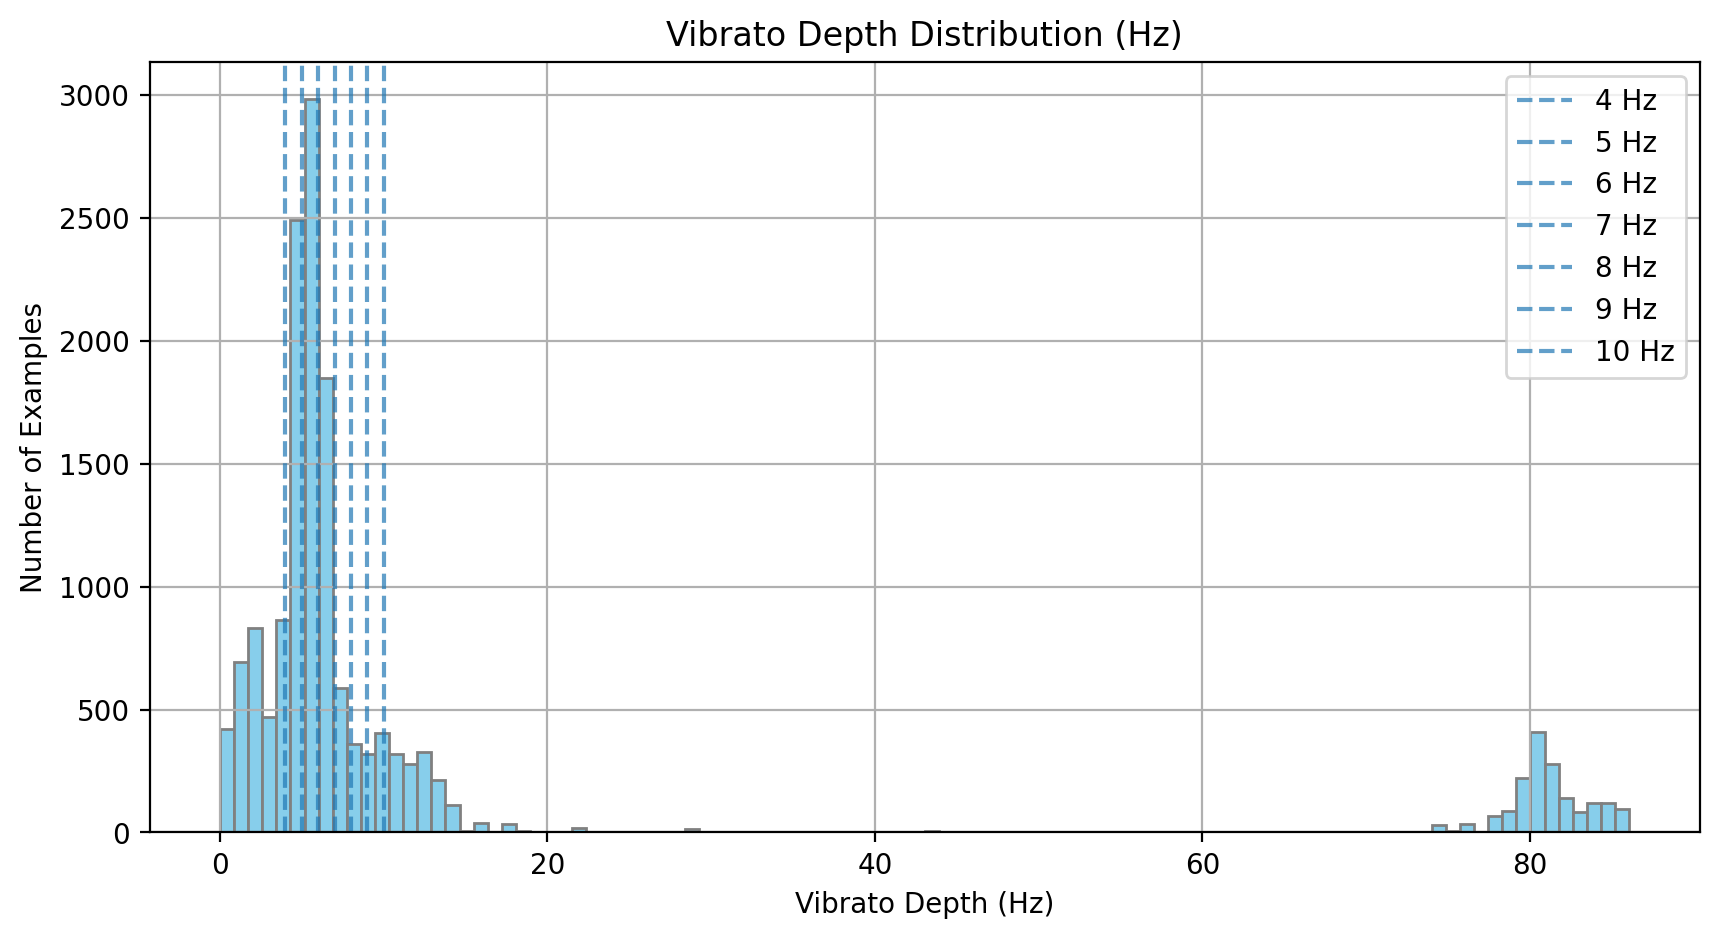

In [ ]:
plot_vibrato_depth_distribution(y_train_rate, threshold_list=[4, 5, 6, 7, 8, 9, 10])

Total examples: 5416

Threshold:    4 Hz → Kept:  1544 examples (28.5%)
Threshold:    5 Hz → Kept:  2281 examples (42.1%)
Threshold:    6 Hz → Kept:  3544 examples (65.4%)
Threshold:    7 Hz → Kept:  4058 examples (74.9%)
Threshold:    8 Hz → Kept:  4244 examples (78.4%)
Threshold:    9 Hz → Kept:  4325 examples (79.9%)
Threshold:   10 Hz → Kept:  4398 examples (81.2%)


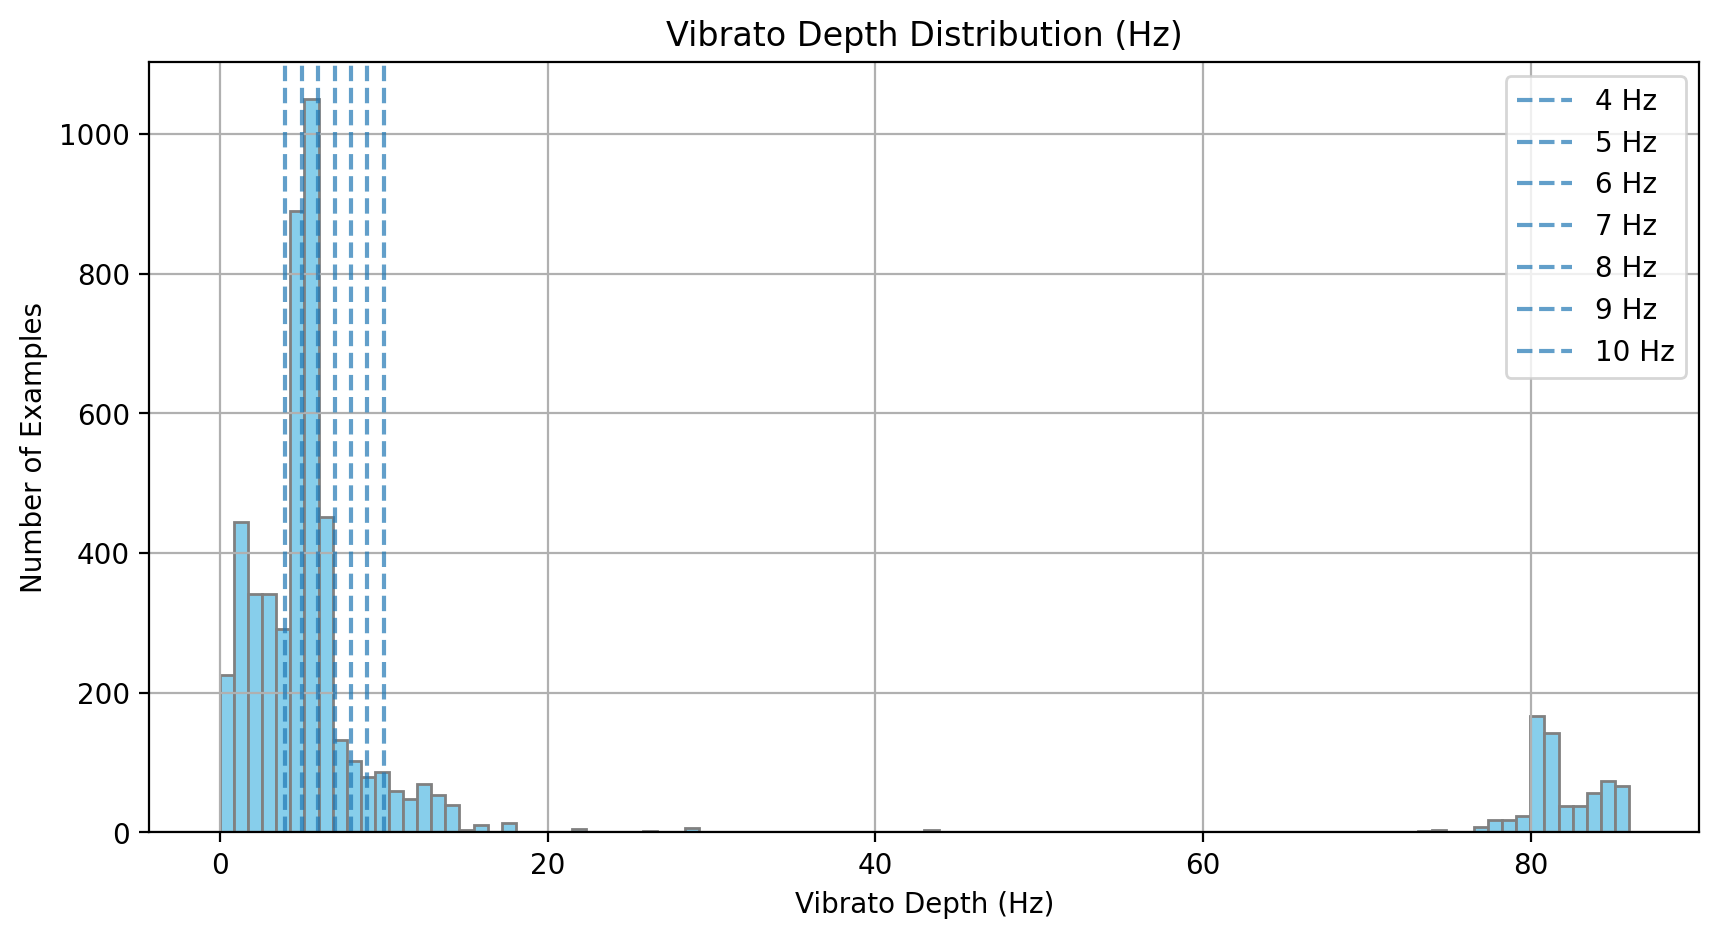

In [ ]:
plot_vibrato_depth_distribution(y_test_rate, threshold_list=[4, 5, 6, 7, 8, 9, 10])